# Imports

In [37]:
# !pip install Boruta #install boruta if this hasnt been done

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import time
from boruta import BorutaPy

sns.set()

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

# Global Config

In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Useful Tools

In [39]:
def convert_datetime_to_season_regression_encoding(datetime):
    winter = (12,1,2)
    spring = (3,4,5)
    summer = (6,7,8)
    fall = (9,10,11)
    
    if datetime.month in winter:
        return 0
    elif datetime.month in spring:
        return 1
    elif datetime.month in summer:
        return 2
    elif datetime.month in fall:
        return 3
    else:
        return -1
    
def target_preprocessing(dataframe):
    dataframe['BirthDateTime'] = pd.to_datetime(dataframe['BirthDate'], unit='s')
    
#     label encoding
    dataframe['SeasonRegressionEncoding'] = 0
    dataframe['SeasonRegressionEncoding'] = dataframe['BirthDateTime'].apply(lambda datetime: convert_datetime_to_season_regression_encoding(datetime))
    
#     Frank-Hal encoding
    dataframe['SeasonFrankHalEncodingSpring'] = 0
    dataframe['SeasonFrankHalEncodingSummer'] = 0
    dataframe['SeasonFrankHalEncodingFall'] = 0

    for ind in range(len(dataframe.index)):
        if dataframe.loc[ind, 'SeasonRegressionEncoding'] == 1:
            dataframe.loc[ind, 'SeasonFrankHalEncodingSpring'] = 1
        elif dataframe.loc[ind, 'SeasonRegressionEncoding'] == 2:
            dataframe.loc[ind, 'SeasonFrankHalEncodingSpring'] = 1
            dataframe.loc[ind, 'SeasonFrankHalEncodingSummer'] = 1
        elif dataframe.loc[ind, 'SeasonRegressionEncoding'] == 3:
            dataframe.loc[ind, 'SeasonFrankHalEncodingSpring'] = 1
            dataframe.loc[ind, 'SeasonFrankHalEncodingSummer'] = 1
            dataframe.loc[ind, 'SeasonFrankHalEncodingFall'] = 1
    return dataframe
        
    
def get_weather_condition(latitude, longitude, date):
    
# These are left blank, in order to run them, you will have to use your own client_id and client_secret
    APP_KEY = "" #DarkSky APP_KEY
    
    print(str(latitude) + "|" + str(longitude) + "|" + str(date) )

    # create the API request URL
    url = "https://dark-sky.p.rapidapi.com/{},{},{}".format(latitude, longitude, date)
    headers = {"x-rapidapi-key": APP_KEY,
               "x-rapidapi-host": "dark-sky.p.rapidapi.com",
               "useQueryString": "true"}
    
    # make the GET request
    results = requests.get(url, headers=headers).json()
    
    return results

def grab_raw_data_from_api(dataframe):
    
#     init the feature columns with NaN
    dataframe["sunriseTimeRaw"] = np.nan
    dataframe["sunsetTimeRaw"] = np.nan
    dataframe["moonPhase"] = np.nan
    dataframe["precipIntensityMax"] = np.nan
    dataframe["precipProbability"] = np.nan
    dataframe["precipTypeRaw"] = np.nan
    dataframe["temperatureHigh"] = np.nan
    dataframe["temperatureLow"] = np.nan
    dataframe["dewPoint"] = np.nan
    dataframe["humidity"] = np.nan
    dataframe["windSpeed"] = np.nan
    dataframe["cloudCover"] = np.nan
    dataframe["uvIndex"] = np.nan
    dataframe["visibility"] = np.nan

#     make api calls to get raw data for each lat, long, date combo, store data in the proper columns
    for ind in dataframe.index:
        result_work_with = get_weather_condition(dataframe.loc[ind, 'Latitude'], dataframe.loc[ind, 'Longitude'], dataframe.loc[ind, 'BirthDate'])
        daily = result_work_with.get('daily', None)

        if daily != None:    
            dataframe.loc[ind, 'sunriseTimeRaw'] = result_work_with['daily']['data'][0].get('sunriseTime', np.nan)
            dataframe.loc[ind, 'sunsetTimeRaw'] = result_work_with['daily']['data'][0].get('sunsetTime', np.nan)
            dataframe.loc[ind, 'moonPhase'] = result_work_with['daily']['data'][0].get('moonPhase', np.nan)
            dataframe.loc[ind, 'precipIntensityMax'] = result_work_with['daily']['data'][0].get('precipIntensityMax', np.nan)
            dataframe.loc[ind, 'precipProbability'] = result_work_with['daily']['data'][0].get('precipProbability', np.nan)
            dataframe.loc[ind, 'precipTypeRaw'] = result_work_with['daily']['data'][0].get('precipType', np.nan)
            dataframe.loc[ind, 'temperatureHigh'] = result_work_with['daily']['data'][0].get('temperatureHigh', np.nan)
            dataframe.loc[ind, 'temperatureLow'] = result_work_with['daily']['data'][0].get('temperatureLow', np.nan)
            dataframe.loc[ind, 'dewPoint'] = result_work_with['daily']['data'][0].get('dewPoint', np.nan)
            dataframe.loc[ind, 'humidity'] = result_work_with['daily']['data'][0].get('humidity', np.nan)
            dataframe.loc[ind, 'windSpeed'] = result_work_with['daily']['data'][0].get('windSpeed', np.nan)
            dataframe.loc[ind, 'cloudCover'] = result_work_with['daily']['data'][0].get('cloudCover', np.nan)
            dataframe.loc[ind, 'uvIndex'] = result_work_with['daily']['data'][0].get('uvIndex', np.nan)
            dataframe.loc[ind, 'visibility'] = result_work_with['daily']['data'][0].get('visibility', np.nan)

#    Being nice and polite when calling external api with a small time delay.
        time.sleep(0.25)

    return dataframe

def sunrise_sunset_clean_up(dataframe):
#     if dayDuration is nan, then sunrise and/or sunset are nan, which means the triple should all be nan 
    dataframe.loc[dataframe["dayDuration"].isna(), "sunriseTimeMinute"] = np.nan
    dataframe.loc[dataframe["dayDuration"].isna(), "sunsetTimeMinute"] = np.nan

    return dataframe

def sunrise_sunset(dataframe):
    #     These are defined from the 0 of the sunrise in minutes, if sunrise is 1/1 23:10 and sunset is 1/2 8:20, then sunriseTimeMinute is 1390, sunsetTimeMinute is 1940 and dayDuration is 550
    dataframe["sunriseTimeMinute"] = np.nan
    dataframe["sunsetTimeMinute"] = np.nan
    dataframe["dayDuration"] = np.nan

    sunrise = pd.to_datetime(dataframe['sunriseTimeRaw'], unit='s')
    sunset = pd.to_datetime(dataframe['sunsetTimeRaw'], unit='s')

    dataframe["sunriseTimeMinute"] = (sunrise.dt.hour*60) + (sunrise.dt.minute)
    dataframe["dayDuration"] = (sunset - sunrise)/np.timedelta64(1,'m')
    dataframe["sunsetTimeMinute"] = dataframe["sunriseTimeMinute"] + dataframe["dayDuration"]

    dataframe = sunrise_sunset_clean_up(dataframe)
    
    return dataframe

def temperature_clean_up(dataframe):
#     if temperatureChange is nan, then temperaturehigh and/or temperaturelow are nan, which means the triple should be nan
    dataframe.loc[dataframe["temperatureChange"].isna(), "temperatureHigh"] = np.nan
    dataframe.loc[dataframe["temperatureChange"].isna(), "temperatureLow"] = np.nan
    
    return dataframe

def temperature_change(dataframe):
    dataframe["temperatureChange"] = np.nan
    dataframe["temperatureChange"] = dataframe["temperatureHigh"] - dataframe["temperatureLow"]
    dataframe = temperature_clean_up(dataframe)
    
    return dataframe

def precip_type_clean_up(dataframe):
#     From what I can tell, if either intensitymax or probability is 0, the other will be 0 as well. If both of them are 0, that means it's not raining or snowing
    dataframe.loc[(dataframe['precipIntensityMax'] == 0) & (dataframe['precipProbability'] == 0), 'precipTypeRaw'] = "None"
    
    return dataframe

def precip_type_one_hot(dataframe):
    dataframe = precip_type_clean_up(dataframe)
    
    precip_type_one_hot = pd.get_dummies(dataframe['precipTypeRaw'], prefix="PrecipType", prefix_sep="_")
    dataframe = pd.merge(dataframe, precip_type_one_hot, left_index=True, right_index=True)
    
    return dataframe

def clean_up_cloud_cover_uvindex_visibility(dataframe):
    dataframe.loc[(dataframe["cloudCover"].isna()) | (dataframe["visibility"].isna()), "uvIndex"] = np.nan
    dataframe.loc[dataframe["uvIndex"].isna(), "cloudCover"] = np.nan
    dataframe.loc[dataframe["uvIndex"].isna(), "visibility"] = np.nan
    
    return dataframe

def clean_up_all_nan(dataframe):
#     sunrise and sunset, in my opinion, is the most important feature in determining the season, so if either is missing, the record is usually completely missing; even if it wasn't I consider it to be completely
#     missing, thus I delete those records from the dataset. If either sunrise or sunset is nan, then dayDuration would be nan.
#     upon further data exploration, I need to delete records where precipIntensityMax, precipProbability, precipTypeRaw, temperatureChange, cloudCover, uvIndex, visibility, dayDuration have nan, see explanation below

    featureTup = ("precipIntensityMax", "precipProbability", "precipTypeRaw", "temperatureChange", "cloudCover", "uvIndex", "visibility", "dayDuration")
    
    for feature in featureTup:
        dataframe = dataframe.loc[dataframe[feature].notna()]
    
    return dataframe

def impute_nan(dataframe):
#     the following features are not related to other features: moonPhase, dewPoint, humidity, windSpeed. They are all numerical features, so if there are any nan, they should be replaced with the average

    featureTup = ("moonPhase", "dewPoint", "humidity", "windSpeed")
    
    for feature in featureTup:
        average = dataframe[feature].mean()
        dataframe.loc[dataframe[feature].isna(), feature] = average
        
    return dataframe
    
def feature_preprocessing_raw_data(dataframe):

    dataframe = sunrise_sunset(dataframe)
    dataframe = temperature_change(dataframe)
    dataframe = precip_type_one_hot(dataframe)
    dataframe = clean_up_cloud_cover_uvindex_visibility(dataframe)
    dataframe = clean_up_all_nan(dataframe)
    dataframe = impute_nan(dataframe)
    
    return dataframe

def show_correlation_heatmap_matrix(dataframe, featureList):
    features = dataframe[featureList]
    plt.figure(figsize=(20,20))
#     NOTE, i took the absolute value of every correlation, because highly negatively correlated values are still highly correlated
    cor = features.corr().abs()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    return

def feat_selector(model):
    featSelector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    
    return featSelector

def rfc(num_trees, oob=False):
    return RandomForestClassifier(n_estimators=num_trees, criterion='gini', n_jobs= -1, class_weight='balanced', max_features='sqrt', oob_score=oob)

def rfr(num_trees, oob=False):
    return RandomForestRegressor(n_estimators=num_trees, criterion='mse', n_jobs= -1, max_features='sqrt', oob_score=oob)

# Load

PLEASE READ: I used ibm cloud platform for working on this notebook, the way I had to load the data is not how this was written. The final submission is written to work with the directory structure of the project structure of the take home project from github. I have not tested the way it is currently written, but it should work.

In [7]:
df_input = pd.read_csv("data/birthdays.csv")
df_input.columns = ["Latitude", "Longitude", "BirthDate"]
df_input.head()

,Latitude,Longitude,BirthDate
0,41.197746,-88.15758,1524447636
1,41.488365,-87.75167,1528162636
2,40.973595,-87.57315,1517638013
3,35.314070,-116.94493,1545264278
4,50.545383,-111.17417,1545864456


# Notes

From what I can understand, location and date maps to weather conditions of a location of a day maps to season. The prediction taking place is, if I give you the location and weather conditions, can you tell me the season.

For encoding the target, first of all, since the seasons are repeating, I am not 100% sure this will work well. The two types of encoding I will be doing is the label encoding, which is fitting for ordinal data; winter comes before spring comes before summer comes before fall. The other is (I am not sure what to call it, I am calling it Frank-Hal encoding), Frank-Hal encoding, it's a combination of one hot encoding and label encoding.

Label Encoding: Winter = 0, Spring = 1, Summer = 2, Fall = 3
Frank Hal: Winter = 000, Spring = 100, Summer = 110, Fall = 111

---------------------------------------------------------------------------------------------------------

We start with picking the following data as features: sunrisetime, sunsettime, moonphase, precipintensitymax, precipprobability, preciptype, temperaturehigh, temperaturelow, dewpoint, humidity, windspeed, cloudcover, uvindex and visibility

Let's add in dayDuration(sunsettime - sunrisetime), temperatureChange(temperaturehigh - temperaturelow)

---------------------------------------------------------------------------------------------------------

There are several interesting situations: 

1. uvindex is 0, cloudcover and/or visibility is nan, this means uvIndex is really nan, and the cloudcover or visibility that isnt nan should be nan

2. everything is nan, which means that record should just be deleted from the dataset

3. temperaturelow or temperaturehigh is nan, which means the other should also be nan, even if they werent, the temperaturechange would be nan

4. precipintensitymax and precipProbability are 0, and precipTypeRaw is nan, but it should be "None", the string, the data isnt missing, it just means it's not snowing, raining, etc.

5. I didn't see sunrise or sunset as nan (while the other isnt), but if that's the case, sunrise, sunset and dayduration should all be nan

---------------------------------------------------------------------------------------------------------

drop from nan: (precipIntensityMax, precipProbability, precipTypeRaw), temperatureChange, (cloudCover, uvIndex, visibility), dayDuration

explanation: these are features that are related to other features, form a tuple of features, imputation would be complicated, because we have to take in account of their relationships

---------------------------------------------------------------------------------------------------------

imputation: moonPhase, dewPoint, humidity, windSpeed.

explanation: as the first cut solution, we will use mode for categorical features and mean for numerical features. All numerical features, so all imputated with mean

---------------------------------------------------------------------------------------------------------

class imbalance: no action taken, see values below.

explanation: While not as good as I hope for, there are no overwhelming imbalance of any of the class. I could enforce exact class balance by grabbing more data in specific manners, upsampling (repeat random records of the under-represented classes) or downsampling (remove random records of the over-represented classes). As a first cut solution, since the imbalance is not as bad as something like a 20:80 or worse, I will process with the dataset as is.

---------------------------------------------------------------------------------------------------------

correlation matrix heatmap: moonPhase, precipIntensityMax, precipProbability, temperatureHigh, temperatureLow, temperatureChange, dewPoint, humidity, windSpeed, cloudCover, uvIndex, visibility, sunriseTimeMinute, sunsetTimeMinute, dayDuration

explanation: these are all the numerical features. Note that for the heatmap, all correlations are the absolute value, this is to show high negatively correlated features. The rule of thumb for the cutoff is 0.8. of the triple (temperatureHigh, temperatureLow, temperatureChange), temperatureHigh and temperatureLow are highly correlated, so I decided to drop temperatureLow. dewPoint is highly correlated to both temperatureHigh and temperatureLow, so I dropped dewPoint. Finally, dayDuration is highly correlated to both sunrise and sunset, so I dropped dayDuration. Surprisingly, sunrise and sunset are not correlated.

---------------------------------------------------------------------------------------------------------

feature selection wrapper method, boruta: using random forest classifier (for multilabel, Frank-Hal encoding, and single label, label encoding) and random forest regressor. max_features would be sqrt of total features. for this step, we will use the entire dataset. current feature list: Latitude, Longitude, moonPhase, precipIntensityMax, precipProbability, PrecipType_None, PrecipType_rain, PrecipType_snow, temperatureHigh, temperatureChange, humidity, windSpeed, cloudCover, uvIndex, visibility, sunriseTimeMinute, sunsetTimeMinute. for the classifier, the label(s): SeasonFrankHalEncodingSpring, SeasonFrankHalEncodingSummer, SeasonFrankHalEncodingFall (for Frank-Hal) and SeasonRegressionEncoding (for label encoding). for the regressor, the label: SeasonRegressionEncoding (for label encoding)

I wasn't 100% sure if this library supports multilabel machine learning. Using the label encoding and regression gave the same subset of viable features: Latitude, Longitude, temperatureHigh, temperatureChange, humidity, uvIndex, sunriseTimeMinute, sunsetTimeMinute. for more details refer to the specific section

---------------------------------------------------------------------------------------------------------

modeling and training: 

1. starting with hyperparameter tuning the number of trees, with a quick for loop, 100 trees is good enough.
2. kfold cross validation using the 3 random forest models. Number of splits is set high to help with class frequencies in the data in each training split.
3. average the train score and test score to provide a better figure for those scores

results: as a prelimary recommendation, we will use random forest classifier with the target encoded by label encoding. Please read below in the corresponding section for details.

final validation score: 0.8185328185328186/1.0

# Target Preprocessing

In [8]:
df_input = target_preprocessing(df_input)

In [9]:
df_input

,Latitude,Longitude,BirthDate,BirthDateTime,SeasonRegressionEncoding,SeasonFrankHalEncodingSpring,SeasonFrankHalEncodingSummer,SeasonFrankHalEncodingFall
0,41.197746,-88.157580,1524447636,2018-04-23 01:40:36,1,1,0,0
1,41.488365,-87.751670,1528162636,2018-06-05 01:37:16,2,1,1,0
2,40.973595,-87.573150,1517638013,2018-02-03 06:06:53,0,0,0,0
3,35.314070,-116.944930,1545264278,2018-12-20 00:04:38,0,0,0,0
4,50.545383,-111.174170,1545864456,2018-12-26 22:47:36,0,0,0,0
5,29.373638,-97.944320,1548972565,2019-01-31 22:09:25,0,0,0,0
6,35.124146,-96.523360,1555512493,2019-04-17 14:48:13,1,1,0,0
7,28.417503,-101.606804,1555891024,2019-04-21 23:57:04,1,1,0,0
8,41.934376,-94.590360,1543961664,2018-12-04 22:14:24,0,0,0,0
9,28.954363,-87.621890,1520765198,2018-03-11 10:46:38,1,1,0,0


# Feature Loading

In [10]:
df_input_with_raw_data = grab_raw_data_from_api(df_input)

41.197746|-88.15758000000001|1524447636
41.488365|-87.75166999999999|1528162636
40.973595|-87.57315|1517638013
35.31407|-116.94493|1545264278
50.545383|-111.17416999999999|1545864456
29.373638|-97.94431999999999|1548972565
35.124146|-96.52336|1555512493
28.417503000000004|-101.606804|1555891024
41.934376|-94.59036|1543961664
28.954363|-87.62189000000001|1520765198
44.18405|-91.54635999999999|1530828689
47.53513|-81.59846|1516017131
28.636688|-87.83057|1546475125
33.181507|-83.49791|1517571320
31.101774|-78.65323000000001|1542489444
36.98338|-106.76723|1546533998
30.902267|-121.95201999999999|1521220680
49.941982|-79.40093|1538656692
40.64638|-103.17709|1527206929
48.785340000000005|-87.77561999999999|1548417881
44.94255|-97.25205|1532434556
31.158457000000002|-92.54634|1540035191
49.91186|-85.6098|1553065319
29.793191999999998|-77.7914|1528250185
37.205055|-91.88584|1546121119
29.599361|-115.60999|1556513323
50.941309999999994|-104.30598|1531630472
42.58708|-86.60515|1526472742
29.3893

In [11]:
df_input_with_raw_data

,Latitude,Longitude,BirthDate,BirthDateTime,SeasonRegressionEncoding,SeasonFrankHalEncodingSpring,SeasonFrankHalEncodingSummer,SeasonFrankHalEncodingFall,sunriseTimeRaw,sunsetTimeRaw,moonPhase,precipIntensityMax,precipProbability,precipTypeRaw,temperatureHigh,temperatureLow,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility
0,41.197746,-88.157580,1524447636,2018-04-23 01:40:36,1,1,0,0,1.524395e+09,1.524444e+09,0.26,0.0007,0.02,rain,64.95,41.32,29.35,0.44,7.46,0.12,9.0,9.997
1,41.488365,-87.751670,1528162636,2018-06-05 01:37:16,2,1,1,0,1.528108e+09,1.528162e+09,0.70,0.0000,0.00,NaN,78.78,62.50,49.23,0.54,6.05,0.06,10.0,9.996
2,40.973595,-87.573150,1517638013,2018-02-03 06:06:53,0,0,0,0,1.517663e+09,1.517699e+09,0.63,0.0054,0.21,snow,40.29,29.66,16.29,0.60,9.46,0.93,2.0,9.997
3,35.314070,-116.944930,1545264278,2018-12-20 00:04:38,0,0,0,0,1.545231e+09,1.545266e+09,0.41,0.0000,0.00,NaN,61.28,33.05,34.33,0.60,3.23,0.00,3.0,9.997
4,50.545383,-111.174170,1545864456,2018-12-26 22:47:36,0,0,0,0,1.545838e+09,1.545867e+09,0.67,NaN,NaN,NaN,22.27,17.60,19.07,0.94,2.77,NaN,0.0,NaN
5,29.373638,-97.944320,1548972565,2019-01-31 22:09:25,0,0,0,0,1.548941e+09,1.548980e+09,0.89,0.0209,0.20,rain,59.10,56.44,50.26,0.89,3.50,1.00,3.0,9.676
6,35.124146,-96.523360,1555512493,2019-04-17 14:48:13,1,1,0,0,1.555502e+09,1.555549e+09,0.45,0.0000,0.00,NaN,76.07,55.87,62.49,0.80,8.71,0.85,6.0,7.978
7,28.417503,-101.606804,1555891024,2019-04-21 23:57:04,1,1,0,0,1.555849e+09,1.555896e+09,0.59,NaN,NaN,NaN,84.09,58.35,54.50,0.59,5.36,NaN,0.0,NaN
8,41.934376,-94.590360,1543961664,2018-12-04 22:14:24,0,0,0,0,1.543930e+09,1.543964e+09,0.93,0.0012,0.18,snow,24.75,18.34,19.79,0.87,4.86,0.98,1.0,6.968
9,28.954363,-87.621890,1520765198,2018-03-11 10:46:38,1,1,0,0,1.520770e+09,1.520813e+09,0.83,0.0000,0.00,NaN,75.35,57.75,64.88,0.83,14.25,0.56,7.0,9.509


# Data Cleaning/Data Engineering

In [12]:
df_input_with_clean_data = feature_preprocessing_raw_data(df_input_with_raw_data)

In [13]:
df_input_with_clean_data

,Latitude,Longitude,BirthDate,BirthDateTime,SeasonRegressionEncoding,SeasonFrankHalEncodingSpring,SeasonFrankHalEncodingSummer,SeasonFrankHalEncodingFall,sunriseTimeRaw,sunsetTimeRaw,moonPhase,precipIntensityMax,precipProbability,precipTypeRaw,temperatureHigh,temperatureLow,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,sunriseTimeMinute,sunsetTimeMinute,dayDuration,temperatureChange,PrecipType_None,PrecipType_rain,PrecipType_snow
0,41.197746,-88.157580,1524447636,2018-04-23 01:40:36,1,1,0,0,1.524395e+09,1.524444e+09,0.26,0.0007,0.02,rain,64.95,41.32,29.35,0.44,7.46,0.12,9.0,9.997,663.0,1481.0,818.0,23.63,0,1,0
1,41.488365,-87.751670,1528162636,2018-06-05 01:37:16,2,1,1,0,1.528108e+09,1.528162e+09,0.70,0.0000,0.00,None,78.78,62.50,49.23,0.54,6.05,0.06,10.0,9.996,620.0,1522.0,902.0,16.28,1,0,0
2,40.973595,-87.573150,1517638013,2018-02-03 06:06:53,0,0,0,0,1.517663e+09,1.517699e+09,0.63,0.0054,0.21,snow,40.29,29.66,16.29,0.60,9.46,0.93,2.0,9.997,780.0,1391.0,611.0,10.63,0,0,1
3,35.314070,-116.944930,1545264278,2018-12-20 00:04:38,0,0,0,0,1.545231e+09,1.545266e+09,0.41,0.0000,0.00,None,61.28,33.05,34.33,0.60,3.23,0.00,3.0,9.997,893.0,1480.0,587.0,28.23,1,0,0
5,29.373638,-97.944320,1548972565,2019-01-31 22:09:25,0,0,0,0,1.548941e+09,1.548980e+09,0.89,0.0209,0.20,rain,59.10,56.44,50.26,0.89,3.50,1.00,3.0,9.676,803.0,1450.0,647.0,2.66,0,1,0
6,35.124146,-96.523360,1555512493,2019-04-17 14:48:13,1,1,0,0,1.555502e+09,1.555549e+09,0.45,0.0000,0.00,None,76.07,55.87,62.49,0.80,8.71,0.85,6.0,7.978,712.0,1501.0,789.0,20.20,1,0,0
8,41.934376,-94.590360,1543961664,2018-12-04 22:14:24,0,0,0,0,1.543930e+09,1.543964e+09,0.93,0.0012,0.18,snow,24.75,18.34,19.79,0.87,4.86,0.98,1.0,6.968,811.0,1369.0,558.0,6.41,0,0,1
9,28.954363,-87.621890,1520765198,2018-03-11 10:46:38,1,1,0,0,1.520770e+09,1.520813e+09,0.83,0.0000,0.00,None,75.35,57.75,64.88,0.83,14.25,0.56,7.0,9.509,726.0,1438.0,712.0,17.60,1,0,0
13,33.181507,-83.497910,1517571320,2018-02-02 11:35:20,0,0,0,0,1.517575e+09,1.517613e+09,0.60,0.0153,0.57,rain,49.75,31.98,27.96,0.56,4.77,0.30,4.0,5.970,750.0,1388.0,638.0,17.77,0,1,0
15,36.983380,-106.767230,1546533998,2019-01-03 16:46:38,0,0,0,0,1.546525e+09,1.546560e+09,0.94,0.0066,0.66,snow,33.41,6.47,4.16,0.81,2.39,0.00,3.0,9.997,862.0,1444.0,582.0,26.94,0,0,1


# Save File

In [ ]:
df_input_with_clean_data.to_csv('data/full_processed_data.csv')

The above line would be how you would save the dataframe to a csv file. In the project directory, under data, labelled birthdays.csv, I generated additional data 3 more times and added them to the original csv file. So there are 2000 records. There is a python script, App.py, that perfromed the above data gathering, engineering, transforming, cleaning, etc. for the full 2000 records dataset, and saved the fully processed data to a file. I then loaded the data below.

In [41]:
df_input_with_clean_data = pd.read_csv("data/full_processed_data.csv")
df_input_with_clean_data

,Unnamed: 0,Latitude,Longitude,BirthDate,BirthDateTime,SeasonRegressionEncoding,SeasonFrankHalEncodingSpring,SeasonFrankHalEncodingSummer,SeasonFrankHalEncodingFall,sunriseTimeRaw,sunsetTimeRaw,moonPhase,precipIntensityMax,precipProbability,precipTypeRaw,temperatureHigh,temperatureLow,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,sunriseTimeMinute,sunsetTimeMinute,dayDuration,temperatureChange,PrecipType_None,PrecipType_rain,PrecipType_snow
0,0,41.197746,-88.157580,1524447636,2018-04-23 01:40:36,1,1,0,0,1.524395e+09,1.524444e+09,0.26,0.0007,0.02,rain,64.95,41.32,29.35,0.44,7.46,0.12,9.0,9.997,663.0,1481.0,818.0,23.63,0,1,0
1,1,41.488365,-87.751670,1528162636,2018-06-05 01:37:16,2,1,1,0,1.528108e+09,1.528162e+09,0.70,0.0000,0.00,None,78.78,62.50,49.23,0.54,6.05,0.06,10.0,9.996,620.0,1522.0,902.0,16.28,1,0,0
2,2,40.973595,-87.573150,1517638013,2018-02-03 06:06:53,0,0,0,0,1.517663e+09,1.517699e+09,0.63,0.0054,0.21,snow,40.29,29.66,16.29,0.60,9.46,0.93,2.0,9.997,780.0,1391.0,611.0,10.63,0,0,1
3,3,35.314070,-116.944930,1545264278,2018-12-20 00:04:38,0,0,0,0,1.545231e+09,1.545266e+09,0.41,0.0000,0.00,None,61.28,33.05,34.33,0.60,3.23,0.00,3.0,9.997,893.0,1480.0,587.0,28.23,1,0,0
4,5,29.373638,-97.944320,1548972565,2019-01-31 22:09:25,0,0,0,0,1.548941e+09,1.548980e+09,0.89,0.0209,0.20,rain,59.10,56.44,50.26,0.89,3.50,1.00,3.0,9.676,803.0,1450.0,647.0,2.66,0,1,0
5,6,35.124146,-96.523360,1555512493,2019-04-17 14:48:13,1,1,0,0,1.555502e+09,1.555549e+09,0.45,0.0000,0.00,None,76.07,55.87,62.49,0.80,8.71,0.85,6.0,7.978,712.0,1501.0,789.0,20.20,1,0,0
6,8,41.934376,-94.590360,1543961664,2018-12-04 22:14:24,0,0,0,0,1.543930e+09,1.543964e+09,0.93,0.0012,0.18,snow,24.75,18.34,19.79,0.87,4.86,0.98,1.0,6.968,811.0,1369.0,558.0,6.41,0,0,1
7,9,28.954363,-87.621890,1520765198,2018-03-11 10:46:38,1,1,0,0,1.520770e+09,1.520813e+09,0.83,0.0000,0.00,None,75.35,57.75,64.88,0.83,14.25,0.56,7.0,9.509,726.0,1438.0,712.0,17.60,1,0,0
8,13,33.181507,-83.497910,1517571320,2018-02-02 11:35:20,0,0,0,0,1.517575e+09,1.517613e+09,0.60,0.0153,0.57,rain,49.75,31.98,27.96,0.56,4.77,0.30,4.0,5.970,750.0,1388.0,638.0,17.77,0,1,0
9,15,36.983380,-106.767230,1546533998,2019-01-03 16:46:38,0,0,0,0,1.546525e+09,1.546560e+09,0.94,0.0066,0.66,snow,33.41,6.47,4.16,0.81,2.39,0.00,3.0,9.997,862.0,1444.0,582.0,26.94,0,0,1


# Class Balance Check

In [42]:
df_input_with_clean_data["SeasonRegressionEncoding"].value_counts()/len(df_input_with_clean_data.index)

1    0.341667
0    0.293750
2    0.194792
3    0.169792
Name: SeasonRegressionEncoding, dtype: float64

Winter: 29.3%

Spring: 34.1%

Summer: 19.4%

Fall: 16.9%

# Correlation Matrix Heatmap

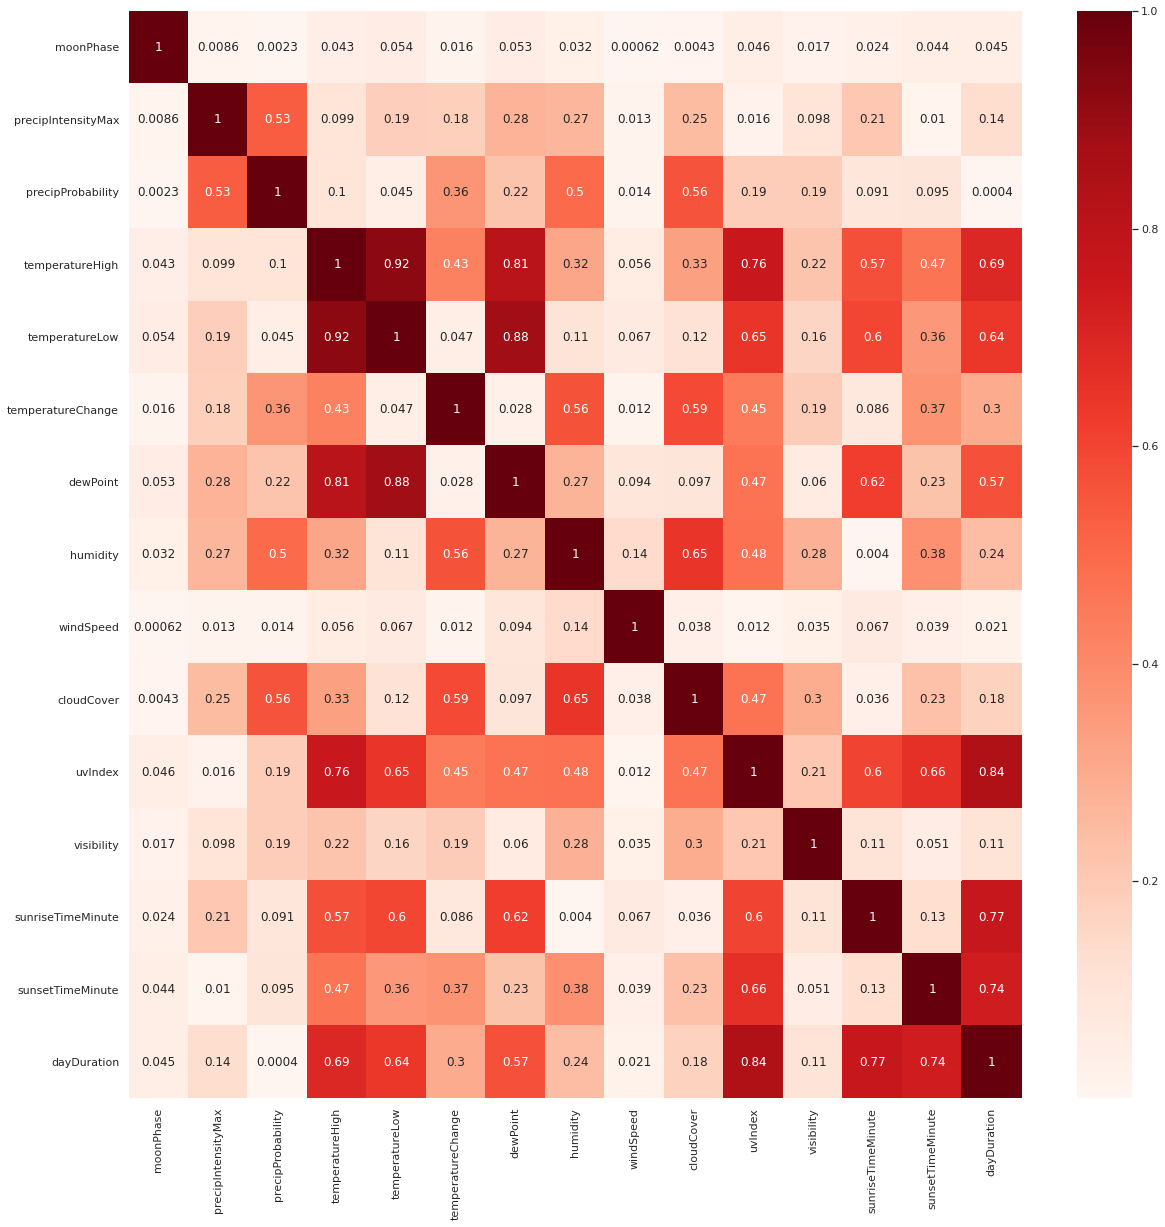

In [27]:
featureList = ["moonPhase", "precipIntensityMax", "precipProbability", "temperatureHigh", "temperatureLow", "temperatureChange", "dewPoint", "humidity", "windSpeed", "cloudCover", "uvIndex", "visibility", "sunriseTimeMinute", "sunsetTimeMinute", "dayDuration"]

show_correlation_heatmap_matrix(df_input_with_clean_data, featureList)

Inclusion List: moonPhase, precipIntensityMax, precipProbability, temperatureHigh, temperatureChange, humidity, windSpeed, cloudCover, uvIndex, visibility, sunriseTimeMinute, sunsetTimeMinute

# Feature Selection Wrapper Method, Boruta Algorithm

In [43]:
# features nad labels
featureList = ['Latitude', 'Longitude', 'moonPhase', 'precipIntensityMax', 'precipProbability', 'PrecipType_None', 'PrecipType_rain', 'PrecipType_snow', 'temperatureHigh', 'temperatureChange', 'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'sunriseTimeMinute', 'sunsetTimeMinute']
features = df_input_with_clean_data[featureList]

frankHalLabelList = ['SeasonFrankHalEncodingSpring', 'SeasonFrankHalEncodingSummer', 'SeasonFrankHalEncodingFall']
frankHalLabels = df_input_with_clean_data[frankHalLabelList]

regressionAndLabelEncodingLabel = df_input_with_clean_data['SeasonRegressionEncoding']

In [19]:
# models for the feature selection process
labelClassificationModel = RandomForestClassifier(criterion='gini', n_jobs= -1, class_weight='balanced', max_features='sqrt')
regressionModel = RandomForestRegressor(criterion='mse', max_features='sqrt')

labelClassFeatSelector = feat_selector(labelClassificationModel)
labelClassFeatSelector.fit(features.values, regressionAndLabelEncodingLabel.values.ravel())

regressionFeatSelector = feat_selector(regressionModel)
regressionFeatSelector.fit(features.values, regressionAndLabelEncodingLabel.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	6
Iteration:

BorutaPy(estimator=RandomForestRegressor(max_features='sqrt', n_estimators=42,
                                         random_state=RandomState(MT19937) at 0x7FA74D3A35A0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FA74D3A35A0, verbose=2)

support_ gives which features are relevant. 

In [21]:
labelClassFeatSelector.support_

array([ True,  True, False, False, False, False, False, False,  True,
        True,  True, False, False,  True, False,  True,  True])

In [22]:
regressionFeatSelector.support_

array([ True,  True, False, False, False, False, False, False,  True,
        True,  True, False, False,  True, False,  True,  True])

In [23]:
['Latitude', 'Longitude', 'moonPhase', 'precipIntensityMax', 'precipProbability', 'PrecipType_None', 'PrecipType_rain', 'PrecipType_snow', 'temperatureHigh', 'temperatureChange', 'humidity', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'sunriseTimeMinute', 'sunsetTimeMinute']

['Latitude',
 'Longitude',
 'moonPhase',
 'precipIntensityMax',
 'precipProbability',
 'PrecipType_None',
 'PrecipType_rain',
 'PrecipType_snow',
 'temperatureHigh',
 'temperatureChange',
 'humidity',
 'windSpeed',
 'cloudCover',
 'uvIndex',
 'visibility',
 'sunriseTimeMinute',
 'sunsetTimeMinute']

Latitude, Longitude, temperatureHigh, temperatureChange, humidity, uvIndex, sunriseTimeMinute, sunsetTimeMinute

# Model and Training

hyperparameter tuning for number of trees using out of bag scores

In [28]:
numTreeList = [100, 200, 300, 400, 500, 600, 700, 800]

for numTree in numTreeList:
    frankHalClassificationModel = rfc(numTree, True)
    frankHalClassificationModel.fit(features, frankHalLabels)
    print("num_tree", numTree)
    print("score", frankHalClassificationModel.oob_score_)

num_tree 100
score 0.8663194444444445
num_tree 200
score 0.8649305555555555
num_tree 300
score 0.8673611111111111
num_tree 400
score 0.8690972222222223
num_tree 500
score 0.8673611111111111
num_tree 600
score 0.8722222222222222
num_tree 700
score 0.8715277777777777
num_tree 800
score 0.865625


This suggests 100, or the default value of number of trees is good enough. Up next we perform kfold cross validation using the 3 random forest algorithm. We will look at the test and train scores. Originally I used stratifiedkfold, which ensures the class frequencies are the same in each fold, but that doesn't play well with multilabel (it should, because Frank-Hal encoding is just a representation of multiclass labels). To remedy this, I will perform a huge number of splits in regular kfold cross validation.

In [34]:
n_splits = 100
cvObj = KFold(n_splits=n_splits, shuffle=True, random_state=42)

frankHalClassificationModel = rfc(100)
labelClassificationModel = rfc(100)
regressionModel = rfr(100)

frankHalResults = cross_validate(frankHalClassificationModel, features, frankHalLabels, cv=cvObj, return_train_score=True)
labelClassResults = cross_validate(labelClassificationModel, features, regressionAndLabelEncodingLabel, cv=cvObj, return_train_score=True)
regressionResults = cross_validate(regressionModel, features, regressionAndLabelEncodingLabel, cv=cvObj, return_train_score=True)

In [35]:
print("Frank-Hal Encoding")
print({"test Score": np.mean(frankHalResults["test_score"]), "Train Score": np.mean(frankHalResults["train_score"])})
print("---------------------------------------------------------------")
print("Label Encoding")
print({"test Score": np.mean(labelClassResults["test_score"]), "Train Score": np.mean(labelClassResults["train_score"])})
print("---------------------------------------------------------------")
print("Regression")
print({"test Score": np.mean(regressionResults["test_score"]), "Train Score": np.mean(regressionResults["train_score"])})

Frank-Hal Encoding
{'test Score': 0.754, 'Train Score': 0.9999894736842105}
---------------------------------------------------------------
Label Encoding
{'test Score': 0.7904444444444444, 'Train Score': 1.0}
---------------------------------------------------------------
Regression
{'test Score': 0.31407761502626097, 'Train Score': 0.9176028046743049}


We can't necessarily rule out random forest regression as a model, because the way the score is computed isn't correct. We would need to round the results to the nearest class and compute the error in a classification problem manner. Since the results for label encoding, specifically for the train score (1.0/1.0), suggests that we're on the right path. Interestingly, Frank-Hal performed worse than regular label encoding of ordinal categories, winter, spring, summer fall. As a first cut solution, my preliminary results suggests random forest classifier using label encoding provides fair outcome. I was rather worried about spring and fall, but for the score to be this high, it means the classification must have worked on those two categories enough.

Below, I will generate a fresh dataset and using a random forest classification model trained on the existing processed dataset, we will make predictions on the fresh dataset. The fresh dataset will be processed in the same manner as the dataset used to train the model. (FOR EXAMPLE, IF THE API CALLS RETURNED INSUFFICIENT DATA TO MAKE A PREDICTION, THAT RECORD WILL BE DELETED, JUST AS BEFORE). This is mostly just as a formality, because of the way kfold cross-validation works.

# Final Validation

In [44]:
labelClassificationModel = rfc(100)
labelClassificationModel.fit(features, regressionAndLabelEncodingLabel)

RandomForestClassifier(class_weight='balanced', max_features='sqrt', n_jobs=-1)

In [47]:
df_fresh_raw = pd.read_csv('data/birthdays_fresh.csv')
df_fresh_raw.columns = ["Latitude", "Longitude", "BirthDate"]
df_fresh_raw.head()

,Latitude,Longitude,BirthDate
0,45.966244,-101.76571,1526250094
1,48.657078,-93.81575,1541677390
2,45.133392,-114.90897,1548574307
3,51.396500,-83.35236,1538324527
4,43.196667,-107.77901,1547002973


In [48]:
df_fresh = target_preprocessing(df_fresh_raw)
df_fresh = grab_raw_data_from_api(df_fresh)
df_fresh = feature_preprocessing_raw_data(df_fresh)
df_fresh

45.966244|-101.76571|1526250094
48.657078000000006|-93.81575|1541677390
45.133392|-114.90897|1548574307
51.3965|-83.35236|1538324527
43.196667|-107.77901000000001|1547002973
44.276394|-100.39584|1551043056
33.652386|-116.74796|1536776782
46.251290000000004|-99.71011999999999|1550898361
44.452644|-89.39215|1528400964
51.914703|-98.56591|1541810422
30.523375|-109.30041499999999|1536153442
38.258083|-122.89711000000001|1524013862
47.11504|-105.8869|1556164413
38.198895|-109.90684499999999|1553399766
37.5782|-94.51269|1541900686
41.915237|-121.43233000000001|1549348978
52.66863299999999|-76.60922|1541462774
32.121876|-91.70902|1550624087
39.840527|-104.43212|1545582782
49.787376|-87.93019|1535920700
41.161471999999996|-102.928925|1518731281
42.434113|-105.42277|1541712163
34.296886|-109.40958400000001|1524001626
35.60605|-95.7615|1541974924
28.521206|-114.91751000000001|1526570529
51.223659999999995|-101.50745|1517777433
42.12401|-88.45508000000001|1514990551
29.937685|-113.26583000000001|

,Latitude,Longitude,BirthDate,BirthDateTime,SeasonRegressionEncoding,SeasonFrankHalEncodingSpring,SeasonFrankHalEncodingSummer,SeasonFrankHalEncodingFall,sunriseTimeRaw,sunsetTimeRaw,moonPhase,precipIntensityMax,precipProbability,precipTypeRaw,temperatureHigh,temperatureLow,dewPoint,humidity,windSpeed,cloudCover,uvIndex,visibility,sunriseTimeMinute,sunsetTimeMinute,dayDuration,temperatureChange,PrecipType_None,PrecipType_rain,PrecipType_snow
1,48.657078,-93.815750,1541677390,2018-11-08 11:43:10,3,1,1,1,1.541683e+09,1.541717e+09,0.05,0.0000,0.00,None,21.85,16.17,14.01,0.80,5.39,1.00,1.0,9.518,795.0,1366.0,571.0,5.68,1,0,0
5,44.276394,-100.395840,1551043056,2019-02-24 21:17:36,0,0,0,0,1.551015e+09,1.551054e+09,0.70,0.0000,0.00,None,4.57,-3.51,-4.16,0.70,22.88,0.33,3.0,6.408,809.0,1464.0,655.0,8.08,1,0,0
6,33.652386,-116.747960,1536776782,2018-09-12 18:26:22,3,1,1,1,1.536759e+09,1.536804e+09,0.13,0.0000,0.00,None,81.55,58.04,33.35,0.28,5.28,0.11,9.0,9.080,810.0,1559.0,749.0,23.51,1,0,0
8,44.452644,-89.392150,1528400964,2018-06-07 19:49:24,2,1,1,0,1.528366e+09,1.528422e+09,0.79,0.0011,0.11,rain,79.44,53.36,52.54,0.66,3.63,0.09,10.0,9.678,615.0,1541.0,926.0,26.08,0,1,0
11,38.258083,-122.897110,1524013862,2018-04-18 01:11:02,1,1,0,0,1.523972e+09,1.524020e+09,0.08,0.0005,0.09,rain,61.09,41.56,38.22,0.71,3.70,0.16,8.0,9.215,814.0,1611.0,797.0,19.53,0,1,0
14,37.578200,-94.512690,1541900686,2018-11-11 01:44:46,3,1,1,1,1.541854e+09,1.541892e+09,0.11,0.0601,0.78,rain,44.21,30.05,15.75,0.59,6.18,0.24,3.0,9.997,774.0,1393.0,619.0,14.16,0,1,0
15,41.915237,-121.432330,1549348978,2019-02-05 06:42:58,0,0,0,0,1.549293e+09,1.549330e+09,0.01,0.0384,0.68,snow,30.96,18.05,24.34,0.86,5.56,0.96,2.0,5.242,916.0,1526.0,610.0,12.91,0,0,1
18,39.840527,-104.432120,1545582782,2018-12-23 16:33:02,0,0,0,0,1.545575e+09,1.545608e+09,0.55,0.0000,0.00,None,52.91,26.99,6.06,0.39,6.56,0.37,2.0,5.299,858.0,1419.0,561.0,25.92,1,0,0
20,41.161472,-102.928925,1518731281,2018-02-15 21:48:01,0,0,0,0,1.518702e+09,1.518741e+09,0.01,0.0000,0.00,None,45.73,10.56,20.29,0.64,15.19,0.62,3.0,9.997,827.0,1467.0,640.0,35.17,1,0,0
21,42.434113,-105.422770,1541712163,2018-11-08 21:22:43,3,1,1,1,1.541685e+09,1.541721e+09,0.05,0.0182,0.90,snow,29.00,13.58,13.85,0.72,8.23,0.62,2.0,6.329,826.0,1428.0,602.0,15.42,0,0,1


In [50]:
freshFeatures = df_fresh[featureList]
freshLabelEncodingLabel = df_fresh['SeasonRegressionEncoding']

In [52]:
print("final validation score:")

print(labelClassificationModel.score(freshFeatures, freshLabelEncodingLabel))

final validation score:
0.8185328185328186


In [54]:
prediction = labelClassificationModel.predict(freshFeatures)
correct = freshLabelEncodingLabel.values

In [58]:
correctCount = 0

for i in range(len(prediction)):
    if prediction[i] == correct[i]:
        correctCount += 1
        print("correct prediction")
    else:
        print("incorrect prediction")
        
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("--------------------------------------------------------------------")
print("correct percentage: ", correctCount/len(prediction))

incorrect prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
correct prediction
incorrect prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
incorrect prediction
correct prediction
incorrect prediction
correct prediction
correct prediction
incorrect prediction
incorrect prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
correct prediction
incorrect